In [4]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
workingDirectory = '/home/h1bennet/strains_rna/results/K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/'
leptinDirectory = '/home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/'
controlDirectory = '/home/h1bennet/strains/data/RNA/control_kupffer/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Make hub to look at individual files

# Import differential gene files for examination and plotting

Make folder for figures

In [6]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

Plot our own version of scatter

In [7]:
comps = ['aj_kupffer_control.vs.aj_kupffer_leptin_6hours.scatter.homer.txt',
         'balbc_kupffer_control.vs.balbc_kupffer_leptin_6hours.scatter.homer.txt']

ids = [['AJ.*Kupffer', 'aj.*leptin_6h'],
       ['BALB.*Kupffer', 'balb.*leptin_6h']]

labels = [['AJ control', 'AJ Leptin 6hours'],
          ['BALBcJ control', 'BALBcJ Leptin 6hours']]

colors = [['#bdbdbd', '#a50f15'],
          ['#bdbdbd', '#08519c']]

# set plotting thresholds
pthresh = 0.05
fontsize=10
labelsize=10
lfcthresh = (np.log2(1.5),2)
dotsize = 1
ax_max = 16
n_yticks = 5
ytickstep = 3
color = '#636363'
filename='leptin_treatment_combined_scatter.png'

aj_kupffer_control.vs.aj_kupffer_leptin_6hours.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9289, 14)
ge selected transcripts (9289, 18)
8018 peaks
39 genes up in group 1
27 genes up in group 2
balbc_kupffer_control.vs.balbc_kupffer_leptin_6hours.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9168, 14)
ge selected transcripts (9168, 18)
9086 peaks
22 genes up in group 1
25 genes up in group 2


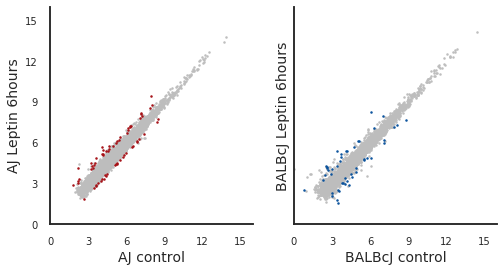

In [8]:
fig, axs = plt.subplots(1,2,
                        figsize=(8,4),
                        sharex=True,
                        sharey=True)
plt.subplots_adjust(wspace=0.2,
                    hspace=0.2)

# set count for labeling axes
count=0

for comp, grep, labs, color, ax in zip(comps, ids, labels, colors, axs.reshape(-1)):
    print(comp)
    de, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        './differential/'+comp,
        './expression/HOMER.rawTPM.txt',
        gene_name_index=True)
    
    # extract columns
    g0 = tpm_mat.columns.str.contains(grep[0])
    g1 = tpm_mat.columns.str.contains(grep[1])
    col = g0 | g1
    
    de['logtpm'] = np.log2(tpm_mat.loc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.padj + 10**(-50))
    de['g0_mean'] = np.log2(tpm_mat.loc[:, g0].mean(1)+1)
    de['g1_mean'] = np.log2(tpm_mat.loc[:, g1].mean(1)+1)
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[de.padj >= pthresh])
    de_sig_fc1 = de.reindex(de.index[(de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])])
    
    # check number of peaks in each group
    print(de_nonsig.shape[0], 'peaks')
    print((de_sig_fc1.log2FoldChange > lfcthresh[0]).sum(), 'genes up in group 1')
    print((de_sig_fc1.log2FoldChange < -lfcthresh[0]).sum(), 'genes up in group 2')
    
    for df, c in zip([de_nonsig, de_sig_fc1],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            #rasterized=True
        )
     
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

    ax.set_xlabel(labs[0], fontsize=labelsize+4)
    ax.set_ylabel(labs[1], fontsize=labelsize+4)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    
    count = count + 1
plt.savefig('./figures/'+filename, bbox_inches='tight')

## Write differential genes to list for metascape

In [9]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [10]:
log2fc = np.log2(1.5)
pval = 0.05
gene_list_dict ={}

In [11]:
for i in np.sort(glob.glob('./differential/c57*c57*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))

for i in np.sort(glob.glob('./differential/balb*balb*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))
    
for i in np.sort(glob.glob('./differential/aj*aj*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))

./differential/balbc_kupffer_control.vs.balbc_kupffer_leptin_6hours.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9168, 14)
ge selected transcripts (9168, 18)
./differential/balbc_kupffer_leptin_6hours.vs.balbc_kupffer_control.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9168, 14)
ge selected transcripts (9168, 18)
./differential/aj_kupffer_control.vs.aj_kupffer_leptin_6hours.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9289, 14)
ge selected transcripts (9289, 18)
./differential/aj_kupffer_leptin_6hours.vs.aj_kupffer_control.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9289, 14)
ge selected transcripts (9289, 18)


In [12]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_kupffer_genes_fc_%.2f_pval_%.2f_.txt' % (log2fc, pval), 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()

balbc_kupffer_leptin_6hours_up
22 genes
balbc_kupffer_control_up
25 genes
aj_kupffer_leptin_6hours_up
37 genes
aj_kupffer_control_up
27 genes


# How many leptin induced genes are common

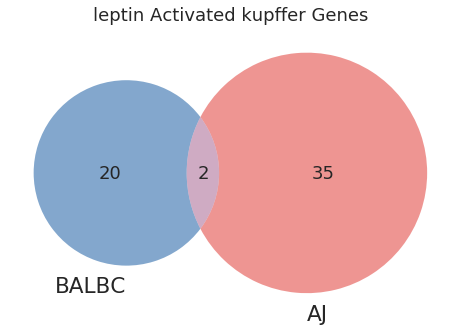

In [13]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn2(subsets=[# set(gene_list_dict['c57_wholeliver_leptin_6hours_up']),
               set(gene_list_dict['balbc_kupffer_leptin_6hours_up']),
               set(gene_list_dict['aj_kupffer_leptin_6hours_up'])],
     ax=ax,
     set_colors=(# '#006d2c',
                 '#08519c', '#de2d26'),
     set_labels=(# 'C57',
                 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('leptin Activated kupffer Genes');

plt.savefig('./figures/venn2_leptin_activated_genes.png', bbox_inches='tight')

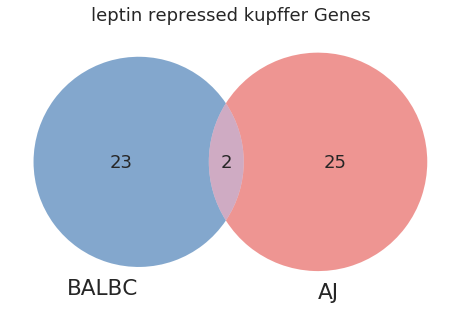

In [14]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn2(subsets=[# set(gene_list_dict['c57_wholeliver_control_young_up']),
               set(gene_list_dict['balbc_kupffer_control_up']),
               set(gene_list_dict['aj_kupffer_control_up'])],
     ax=ax,
     set_colors=(# '#006d2c',
                 '#08519c', '#de2d26'),
     set_labels=(# 'C57',
                 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('leptin repressed kupffer Genes');

plt.savefig('./figures/venn2_leptin_repressed_genes.png', bbox_inches='tight')

### Pull sets for manual examination

activated genes

In [15]:
# all3 = set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(set(gene_list_dict['balbc_kupffer_leptin_6hours_up']).intersection(gene_list_dict['c57_kupffer_leptin_6hours_up']))
# C57_balbc = set(gene_list_dict['c57_kupffer_leptin_6hours_up']).intersection(set(gene_list_dict['balbc_kupffer_leptin_6hours_up']).difference(all3))
# C57_aj = set(gene_list_dict['c57_kupffer_leptin_6hours_up']).intersection(set(gene_list_dict['aj_kupffer_leptin_6hours_up']).difference(all3))
balbc_aj = set(gene_list_dict['balbc_kupffer_leptin_6hours_up']).intersection(gene_list_dict['aj_kupffer_leptin_6hours_up'])# .difference(all3)
# C57_private = set(gene_list_dict['c57_kupffer_leptin_6hours_up']).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
# balbc_private = set(gene_list_dict['balbc_kupffer_leptin_6hours_up']).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
# aj_private = set(gene_list_dict['aj_kupffer_leptin_6hours_up']).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

In [16]:
# genesets = [aj_private, C57_private, balbc_private]
# genesetnames = ['aj_private', 'c57_private', 'balbc_private']
# for listname, genelist in zip(genesetnames, genesets):
#     with open('./gene_lists/'+listname+'_wholeliver_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
#         f.write('Gene\n')
#         for i in genelist:
#             f.write(i+'\n')
#         f.close()

# Plot specific genes as barplots

In [17]:
tpm_mat = pd.read_csv('./expression/rawT.txt', sep='\t', index_col=0)

In [18]:
tpm_mat.columns

Index(['c57_kupffer_control_C5701C', 'c57_kupffer_control_C5701D',
       'c57_kupffer_leptin_6hours_rep1', 'balbc_kupffer_control_BALB01C',
       'balbc_kupffer_control_BALB01D', 'balbc_kupffer_leptin_6hours_rep1',
       'balbc_kupffer_leptin_6hours_rep3', 'aj_kupffer_control_AJ01C',
       'aj_kupffer_control_AJ01D', 'aj_kupffer_leptin_6hours_rep1',
       'aj_kupffer_leptin_6hours_rep2'],
      dtype='object')

In [19]:
groups = [[0,1],
          [2],
          [3,4],
          [5,6],
          [7,8],
          [9,10]]

group_labels = ['C57BL/6J Kupffer Control young',
                'C57BL/6J Kupffer leptin 6 hours',
                'Balb/cJ Kupffer Control young',
                'Balb/cJ Kupffer leptin 6 hours',
                'AJ Kupffer Control young',
                'AJ Kupffer leptin 6 hours',]

colors = ['#74c476',
          '#006d2c',
          '#6baed6',
          '#08519c',
          '#de2d26',
          '#a50f15']

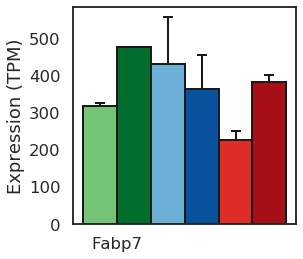

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))

gene_list_bar_plot(['Fabp7'],
                   tpm_mat,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width = 0.15,
                   ax=ax)

ax.get_legend().remove()

# look at  overlap with strain specific gene sets

Read in strain specific gene sets

In [21]:
strain_spec_kc_genes = {}
for gene_list_path in glob.glob('/home/h1bennet/strains_rna/results/K00_Strains_Control_Kupffer_RNA/gene_lists/*txt'):
    gene_list = []
    gene_list_name = gene_list_path.split('/')[-1].split('_kupffer')[0]
    with open(gene_list_path, 'r') as f:
        strain_spec_kc_genes[gene_list_name] = [i.strip() for i in f.readlines()][1:]
    

There is mild overlap between these gene sets

In [22]:
for key in strain_spec_kc_genes.keys():
    print(key)
    print(len(set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(strain_spec_kc_genes[key])))
    print(set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(strain_spec_kc_genes[key]))

aj_intersection
0
set()
balb_intersection
3
{'Trem2', 'Ifi27l2a', 'Lgals1'}
c57_intersection
0
set()
balb_union
6
{'Trem2', 'Rcan1', 'Per1', 'Anxa2', 'Ifi27l2a', 'Lgals1'}
aj_union
3
{'Lgals1', 'Marco', 'Ikbke'}
c57_union
6
{'Mki67', 'D17H6S56E-5', 'Per1', 'Marco', 'Rgs1', 'Ikbke'}


In [25]:
print(len(strain_spec_kc_genes['balb_union']))

230


In [26]:
print(len(set(gene_list_dict['aj_kupffer_leptin_6hours_up'])))

37


In [23]:
for key in strain_spec_kc_genes.keys():
    print(key)
    print(len(set(gene_list_dict['aj_kupffer_control_up']).intersection(strain_spec_kc_genes[key])))
    print(set(gene_list_dict['aj_kupffer_control_up']).intersection(strain_spec_kc_genes[key]))

aj_intersection
0
set()
balb_intersection
0
set()
c57_intersection
0
set()
balb_union
2
{'Lepr', 'Rnf144b'}
aj_union
4
{'Vipr1', 'Fosb', 'Mturn', 'Rnf144b'}
c57_union
4
{'Ncoa1', 'Lepr', 'Vipr1', 'Fosb'}


In [27]:
len(strain_spec_kc_genes['aj_union'])

227

In [28]:
print(len(set(gene_list_dict['aj_kupffer_control_up'])))

27


In [30]:
import scipy.stats as stats

## test enrichment of balb union genes in leptin induced set

Contingency table explained:  

genes in dataset: 9289  
genes 2 fold up in balb union: 230  
genes 1.5 fold induced by leptin in aj: 37  
overlap between two gene sets: 6.  

|  |Not in A              | in A |
|:---:|:----------------------:|:-----:
Not in B|9289 - 224 - 31 - 6 | 37-6
In B|230-6                | 6

In [31]:
stats.fisher_exact([[9289-224-31, 37-6], [230-6, 6]], alternative='greater')

(7.8058755760368665, 0.0002628836657345142)

In [32]:
stats.fisher_exact([[9289-223-23, 27-4], [227-4, 4]], alternative='greater')

(7.052446870735036, 0.003912133605260192)

# Lets look at overlap between BALB and AJ differential genes in particular

In [35]:
pval = 0.05
log2fc = np.log2(1.5)
for i in np.sort(glob.glob('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.balbcj_control.scatter.txt')):
    print(i)
    # read in gene expression data
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    # select differential genes
    # df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('/')[-1]] = list(sig_genes)

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.balbcj_control.scatter.txt


In [58]:
df.shape

(7619, 7)

In [50]:
import scipy.stats as stats

In [56]:
key='aj_control.vs.balbcj_control.scatter.txt'
print(key)
print(len(set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(gene_list_dict[key])))
print(set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(gene_list_dict[key]))

aj_control.vs.balbcj_control.scatter.txt
10
{'Sem1', 'Anxa3', 'Fabp7', 'Hspa1a', 'Lgals1', 'Rpl37rt', 'Ifi27l2a', 'Trem2', 'Rcan1', 'Per1'}


In [57]:
print(len(gene_list_dict[key]))

239


## test enrichment of balb up vs aj genes in leptin induced set

Contingency table explained:
genes in dataset: 7619
genes 2 fold up in balb vs aj: 239
genes 1.5 fold induced by leptin in aj: 37
overlap between two gene sets: 10.

|  |Not in A              | in A |
|:---:|:----------------------:|:-----:
Not in B|7353 - 229 - 27 - 10 | 37-10
In B|229-10                | 10

In [60]:
stats.fisher_exact([[7353, 27], [229, 10]], alternative='greater')

(11.892285298398836, 1.2644931614576053e-07)

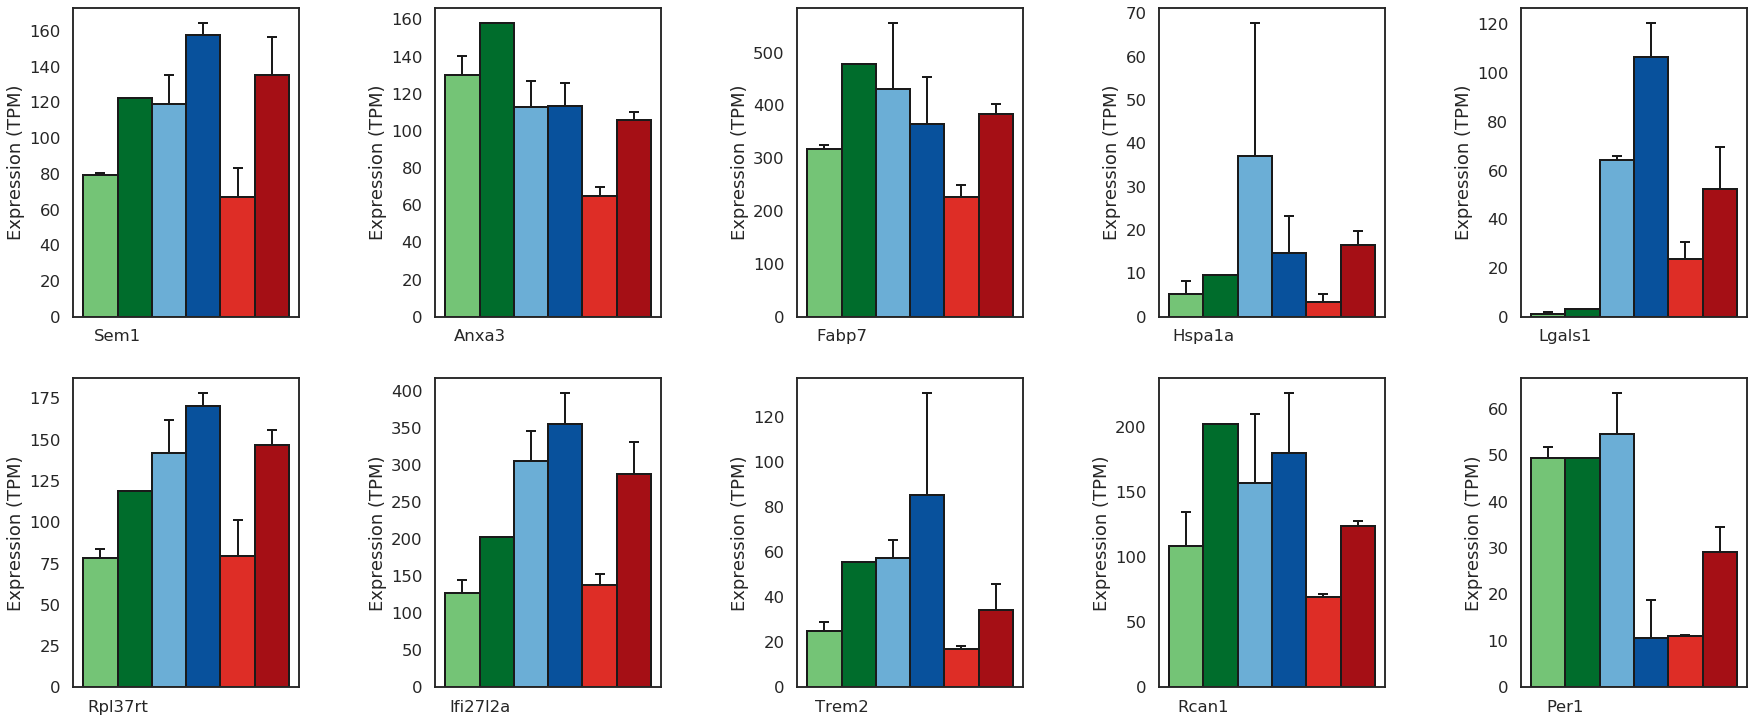

In [44]:
gene_list = set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(gene_list_dict[key])

fig, axs = plt.subplots(2, int(len(gene_list)/2), figsize=(3*len(gene_list), 1.25*len(gene_list)))
plt.subplots_adjust(wspace=0.6)


for gene, ax in zip(gene_list, axs.flat):
    gene_list_bar_plot([gene],
                       tpm_mat,
                       groups=groups,
                       group_labels = group_labels,
                       colors = colors,
                       width = 0.15,
                       ax=ax)

    ax.get_legend().remove()

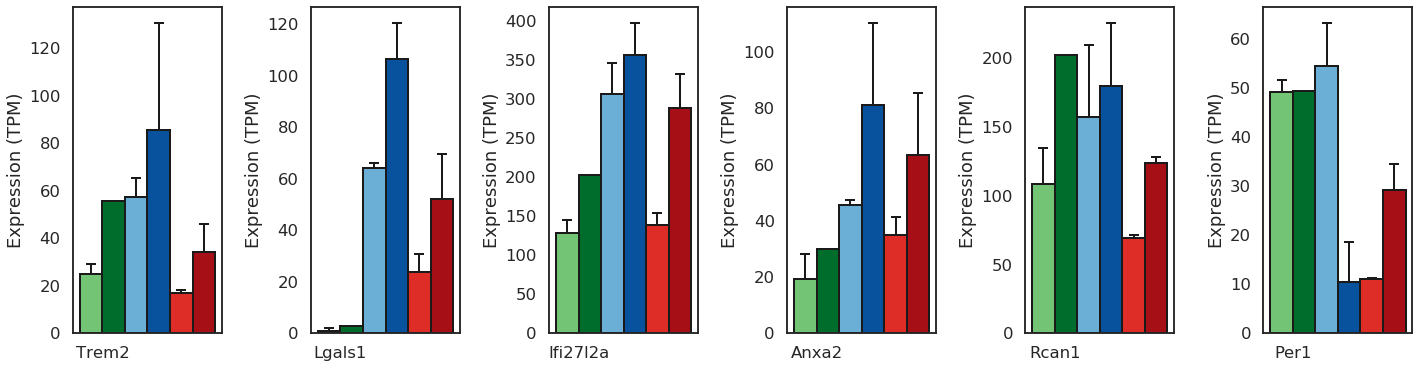

In [27]:
gene_list = ['Trem2', 'Lgals1', 'Ifi27l2a', 'Anxa2', 'Rcan1', 'Per1']

fig, axs = plt.subplots(1, len(gene_list), figsize=(4*len(gene_list), len(gene_list)))
plt.subplots_adjust(wspace=0.6)


for gene, ax in zip(gene_list, axs.flat):
    gene_list_bar_plot([gene],
                       tpm_mat,
                       groups=groups,
                       group_labels = group_labels,
                       colors = colors,
                       width = 0.15,
                       ax=ax)

    ax.get_legend().remove()

In [138]:
for key in strain_spec_kc_genes.keys():
    print(key)
    print(len(set(gene_list_dict['balbc_kupffer_leptin_6hours_up']).intersection(strain_spec_kc_genes[key])))
    print(set(gene_list_dict['balbc_kupffer_leptin_6hours_up']).intersection(strain_spec_kc_genes[key]))

aj_intersection
0
set()
balb_intersection
1
{'Lgals1'}
c57_intersection
0
set()
balb_union
1
{'Lgals1'}
aj_union
4
{'Lgals1', 'Zdhhc2', 'Pim1', 'C3'}
c57_union
3
{'Plac8', 'Pim1', 'C3'}
